In [8]:
# Step 1: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [9]:
# Step 2: Load Training & Testing Data

train_df = pd.read_csv("customer_churn_dataset-testing-master.csv")
test_df = pd.read_csv("customer_churn_dataset-testing-master.csv")

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)
print(train_df.head())

Train Shape: (64374, 12)
Test Shape: (64374, 12)
   CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  \
0           1   22  Female      25               14              4   
1           2   41  Female      28               28              7   
2           3   47    Male      27               10              2   
3           4   35    Male       9               12              5   
4           5   53  Female      58               24              9   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0             27             Basic         Monthly          598   
1             13          Standard         Monthly          584   
2             29           Premium          Annual          757   
3             17           Premium       Quarterly          232   
4              2          Standard          Annual          533   

   Last Interaction  Churn  
0                 9      1  
1                20      0  
2                21      0  
3          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB
None
Churn
0    0.526315
1    0.473685
Name: proportion, dtype: float64


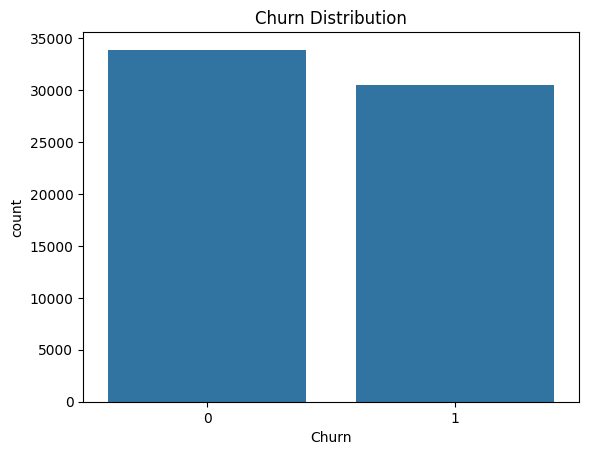

In [10]:
# Step 3: Explore Training Data

print(train_df.info())
print(train_df['Churn'].value_counts(normalize=True))  # Churn distribution

# Quick visualization
sns.countplot(x='Churn', data=train_df)
plt.title("Churn Distribution")
plt.show()


In [11]:
# Step 4: Data Preprocessing


# Drop irrelevant column
if 'customerID' in train_df.columns:
    train_df.drop('customerID', axis=1, inplace=True)
    test_df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges (string → numeric)
if 'TotalCharges' in train_df.columns:
    train_df['TotalCharges'] = pd.to_numeric(train_df['TotalCharges'], errors='coerce')
    test_df['TotalCharges'] = pd.to_numeric(test_df['TotalCharges'], errors='coerce')

# Handle missing values
train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

# Encode categorical columns
cat_cols = train_df.select_dtypes(include=['object']).columns

encoder = LabelEncoder()
for col in cat_cols:
    if col != 'Churn':   # Don't encode target
        train_df[col] = encoder.fit_transform(train_df[col])
        test_df[col] = encoder.transform(test_df[col])

# Encode target (Yes/No → 1/0)
train_df['Churn'] = train_df['Churn'].map({'Yes':1, 'No':0})

In [14]:
# Step 5: Train-Validation Split

X = train_df.drop("Churn", axis=1)
y = train_df["Churn"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(test_df)  # Apply same scaling to test set

ValueError: Input y contains NaN.

In [13]:
# Step 6: Model Training


# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_val)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)


NameError: name 'X_train' is not defined

In [ ]:
# Step 7: Model Evaluation

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n📌 {model_name} Results")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

evaluate_model(y_val, y_pred_lr, "Logistic Regression")
evaluate_model(y_val, y_pred_rf, "Random Forest")
evaluate_model(y_val, y_pred_xgb, "XGBoost")

# ROC-AUC (compare models)
for model, pred in [("LogReg", y_pred_lr), ("RandomForest", y_pred_rf), ("XGBoost", y_pred_xgb)]:
    auc = roc_auc_score(y_val, pred)
    print(f"{model} ROC-AUC: {auc:.3f}")

In [ ]:
# Step 8: Final Test Prediction

best_model = rf  # Example: Random Forest performed best

test_predictions = best_model.predict(X_test)
print("Test Predictions:", test_predictions[:20])  # First 20 predictions

# If test set has true Churn labels (optional)
# print(classification_report(test_df["Churn"], test_predictions))